 t =  100.00189989578527
 size = ( 322  x  402 )


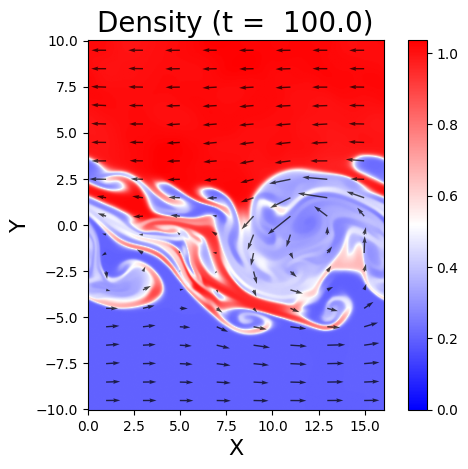

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import openmhd
# dummy index
vx=0;vy=1;vz=2;pr=3;ro=4;bx=5;by=6;bz=7;ps=8

input_data_file = "./data/case001_20251211-171638/field-00020.dat"

# reading the data ...
x,y,t,data = openmhd.data_read(input_data_file)
# reading the data (partial domain: [ix1,ix2] x [jx1,jx2])
# x,y,t,data = openmhd.data_read("data/field-00015.dat",ix2=101,jx1=50,jx2=101)

# clearing the current figure, if any
plt.clf()
# extent: [left, right, bottom, top]
extent=[x[0],x[-1],y[0],y[-1]]
# 2D plot (vmin/mymin: minimum value, vmax/mymax: max value)
# Note: ().T is necessary for 2-D plot routines (imshow/pcolormesh...)
tmp = np.ndarray((x.size,y.size),np.double)
tmp[:,:] = data[:,:,ro]
mymax = max(tmp.max(), -tmp.min()) if( tmp.max() > 0.0 ) else 0.0
mymin = min(tmp.min(), -tmp.max()) if( tmp.min() < 0.0 ) else 0.0
myimg = plt.imshow(tmp.T,origin='lower',vmin=mymin,vmax=mymax,cmap='bwr',extent=extent)

# image operations (e.g. colormaps)
# myimg.set_cmap('jet')
# myimg.set_cmap('RdBu_r')  # colortable(70,/reverse) in IDL
# myimg.set_cmap('seismic')
# myimg.set_cmap('bwr')
# myimg.set_cmap('gnuplot2')

# useful options
# plt.grid()
plt.xlabel("X",size=16)
plt.ylabel("Y",size=16)
plt.title('Density (t = %6.1f)' % t, size=20)

# color bar (next to myimg)
plt.colorbar()

# flow vectors
# Note: ().T is necessary for a 2-D array
myxsub = 40; myysub = 20; myxsub0 = int(myxsub/2); myysub0 = int(myysub/2)
myvec = plt.quiver( x[myxsub0::myxsub],
                    y[myysub0::myysub],
                    data[myxsub0::myxsub,myysub0::myysub,vx].T,
                    data[myxsub0::myxsub,myysub0::myysub,vy].T,
                    alpha=0.7,angles='xy')

# plot
plt.show()

# image file
# plt.savefig('output.png', dpi=144)

# end

In [12]:
# Interactive version by jupyter-notebook & ipywidgets
# To use it, please install jupyter and ipywidgets.
# $ pip3 install jupyter ipywidgets
# $ [ pip3 install -U jupyter ipywidgets ]
# Then one can run this sample
# $ jupyter-notebook plot.ipynb

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import openmhd
import glob
from ipywidgets import interact
# dummy index
vx=0;vy=1;vz=2;pr=3;ro=4;bx=5;by=6;bz=7;ps=8

data_directory = "data/case001_20251211-171638/"
data_directory = "./data/case002_20251211-171914/"

labels={"Vx":0,"Vy":1,"Vz":2,"Pressure":3,"Density":4,"Bx":5,"By":6,"Bz":7,"Psi":8}
cmaps=['jet','RdBu_r','bwr','seismic','gnuplot2']
datalist = sorted(glob.glob(data_directory + 'field-?????.dat')) # filelist (regular expression)

@interact (inputdata=datalist,mylabel=labels,mycmap=cmaps)
def plot(inputdata=data_directory + 'field-00020.dat',mylabel=4,mycmap='jet'):
    # reading the data ...
    x,y,t,data = openmhd.data_read(inputdata)
    # reading the data (partial domain: [ix1,ix2] x [jx1,jx2])
    # x,y,t,data = openmhd.data_read("data/field-%05d.dat" % 20,ix1=0,ix2=100,jx1=11)
    print(inputdata)

    # extent: [left, right, bottom, top]
    extent=[x[0],x[-1],y[0],y[-1]]
    # 2D plot (vmin/mymin: minimum value, vmax/mymax: max value)
    # Note: ().T is necessary for 2-D plot routines (imshow/pcolormesh...)
    tmp = np.ndarray((x.size,y.size),np.double)
    tmp[:,:] = data[:,:,mylabel]
    mymax = max(tmp.max(), -tmp.min()) if( tmp.max() > 0.0 ) else 0.0
    mymin = min(tmp.min(), -tmp.max()) if( tmp.min() < 0.0 ) else 0.0
    myimg = plt.imshow(tmp.T,origin='lower',vmin=mymin,vmax=mymax,cmap=mycmap,extent=extent)

    # useful options
    # plt.grid()
    plt.xlabel("X",size=16)
    plt.ylabel("Y",size=16)
    plt.title('%s (t = %6.1f)' % ( (list(labels.keys()))[mylabel], t), size=20)
    # colorbar
    plt.colorbar()

    # flow vectors
    # Note: ().T is necessary for a 2-D array
    myxsub = 40; myysub = 20; myxsub0 = int(myxsub/2); myysub0 = int(myysub/2)
    myvec = plt.quiver( x[myxsub0::myxsub],
                        y[myysub0::myysub],
                        data[myxsub0::myxsub,myysub0::myysub,vx].T,
                        data[myxsub0::myxsub,myysub0::myysub,vy].T,
                        alpha=0.7,angles='xy')
    plt.show()


interactive(children=(Dropdown(description='inputdata', index=20, options=('./data/case002_20251211-171914/fie…